# Sample mean estimation details

I find this is a very sneaky detail, and I have not seen anyone explain it in any other textbook.

It seems to me there is a "slight of hand" when we switch from talking about:
- (A) the sampling distribution centred at the sample mean (which corresponds to the realistic, best effort scenario when we don't know either the population mean or the population var)
- (B) the sampling distribution centred around the known population mean (as we can obtain from simulation when the population parameters are known)

There are basically two possible pictures:

- Picture A: `norm(kbar, sehat)`:
  a realistic experimenter who only knows ksample
  will make their "best guess" of the population mean as `kbar = mean(ksample)`.
  We can plot the sampling distribution centered at kbar.
  I think nobody wants to shows this kind of figure because it looks really bad.
  Look how far off the CLT and bootstrap approximations are
  relative to the true population mean mu=1000.

- Picture B: `norm(mu_K, sehat)`:
  a hypothetical distribution centered on true population mean.
  This plot describes some hypothetical half-knowledge scenario,
  where the experimenter knows population mean mu,
  but doesn't know the variance,
  so we use CLT or BOOT for the estimated dispersion,
  but show dist. centered at muK (the population mean).


It's a tricky business... because Picture A is very ugly (reader might feel estimation process is hopeless), but it is real (shows how to calc. CI for population mean).

On the other hand Picture B is nicer to see (yeeey look how nicely the fat tails of the t-distribution fit the histogram of kbars better), but doesn't describe any realistic scenario, or calculation we actually do.


Perhaps we need a third picture, to explain we're really talking...

- Picture C: `norm(0, sehat)`: the distribution of ∆ = kbar - muK,
  which shows the deviation of the sample mean from the population mean.
  This way it becomes clear the symmetry of the situation:
  (1) if you know mu, then you have a distribution of where xbars might fall,
  and (2) if you know kbar, then you have a distribution for where the unknown mu might be.

I might have to show Picture C because I'm ashamed of showing Picture A and I think Picture B is misleading...

Question: If we're going to discuss the distribution of `kbar - muK`,
perhaps we might as well go all the way to a pivotal quantity  `t  = (kbar - muK)/sehat`.


#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Plot helper functions
from plot_helpers import plot_pdf
from plot_helpers import savefigure

In [3]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn't work
from plot_helpers import RCPARAMS
RCPARAMS.update({'figure.figsize': (10, 3)})   # good for screen
# RCPARAMS.update({'figure.figsize': (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# Useful colors
snspal = sns.color_palette()
blue, orange, purple = snspal[0], snspal[1], snspal[4]

# High-resolution please
%config InlineBackend.figure_format = 'retina'

# Where to store figures
DESTDIR = "figures/stats/estimators"

<Figure size 640x480 with 0 Axes>

In [4]:
# set random seed for repeatability
np.random.seed(42)

## Estimators

In [5]:
def mean(sample):
    return sum(sample) / len(sample)

# ALT. use .mean() method on a Pandas series
# ALT. use np.mean(sample)



def var(sample):
    xbar = mean(sample)
    sumsqdevs = sum([(xi-xbar)**2 for xi in sample])
    return sumsqdevs / (len(sample)-1)

# ALT. use .var() method on a Pandas series
# ALT. use np.var(sample, ddof=1)




def std(sample):
    s2 = var(sample)
    return np.sqrt(s2)

# ALT. use .std() method on a Pandas series
# ALT. use np.std(sample, ddof=1)

## Particular sample: kombucha Batch 02


In [6]:
kombucha = pd.read_csv("../datasets/kombucha.csv")
# kombucha

In [7]:
batch02 = kombucha[kombucha["batch"]==2]
ksample02 = batch02["volume"]
n = ksample02.count()
n

20

In [8]:
ksample02.values

array([ 995.83,  999.44,  978.64, 1016.4 ,  982.07,  991.58, 1005.03,
        987.55,  989.42,  990.91, 1005.51, 1022.92, 1000.42,  988.82,
       1005.39,  994.04,  999.81, 1011.75,  992.52, 1000.09])

In [9]:
mean(ksample02)

997.9069999999999

^ underestimate of true population mean $\mu_K = 1000$ ...

In [10]:
std(ksample02)

11.149780314097285

^ overestimate of true population std $\sigma_K = 10$...

## Population

We assume the kombucha volume (when the production is regular/stable) can be modelled as the random variable $K \sim \mathcal{N}(\mu_K=1000, \sigma_K=10)$.


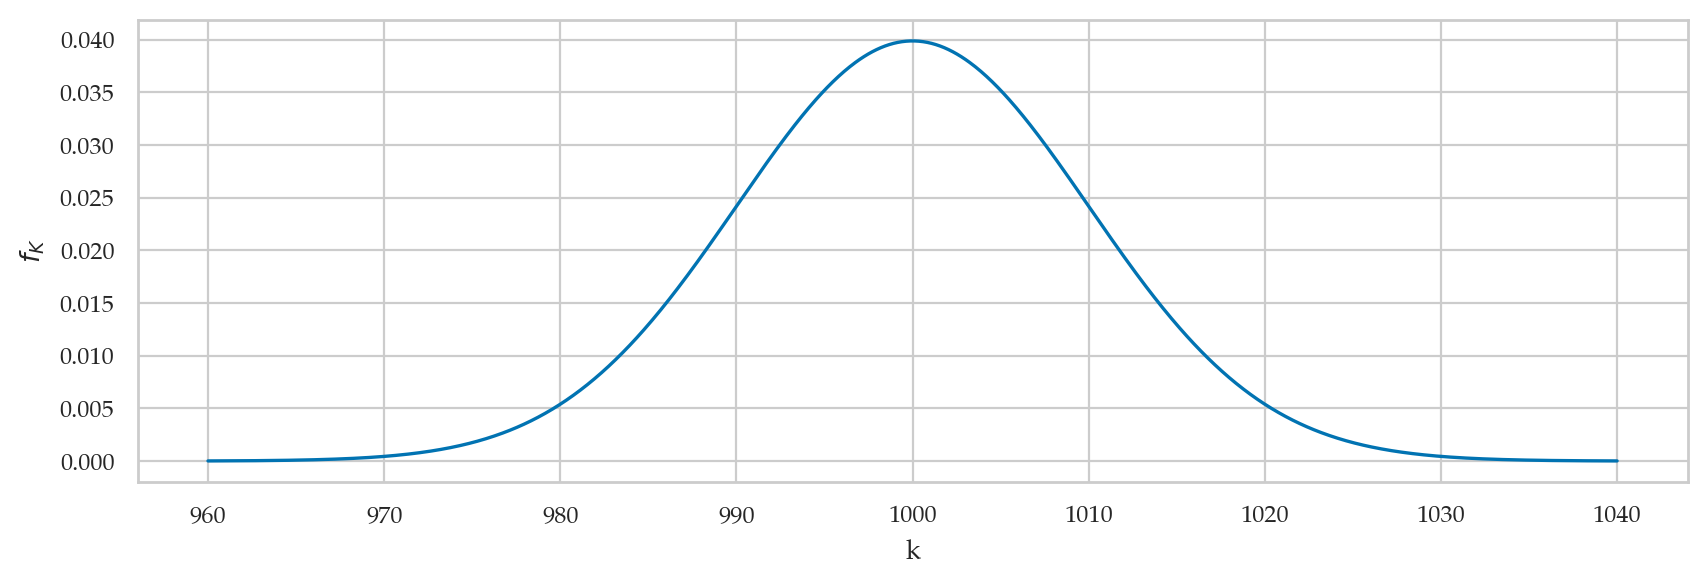

In [11]:
from scipy.stats import norm
muK = 1000
sigmaK = 10
rvK = norm(muK, sigmaK)

ax = plot_pdf(rvK, xlims=[960,1040], rv_name="K")

## True sampling distribution of the mean

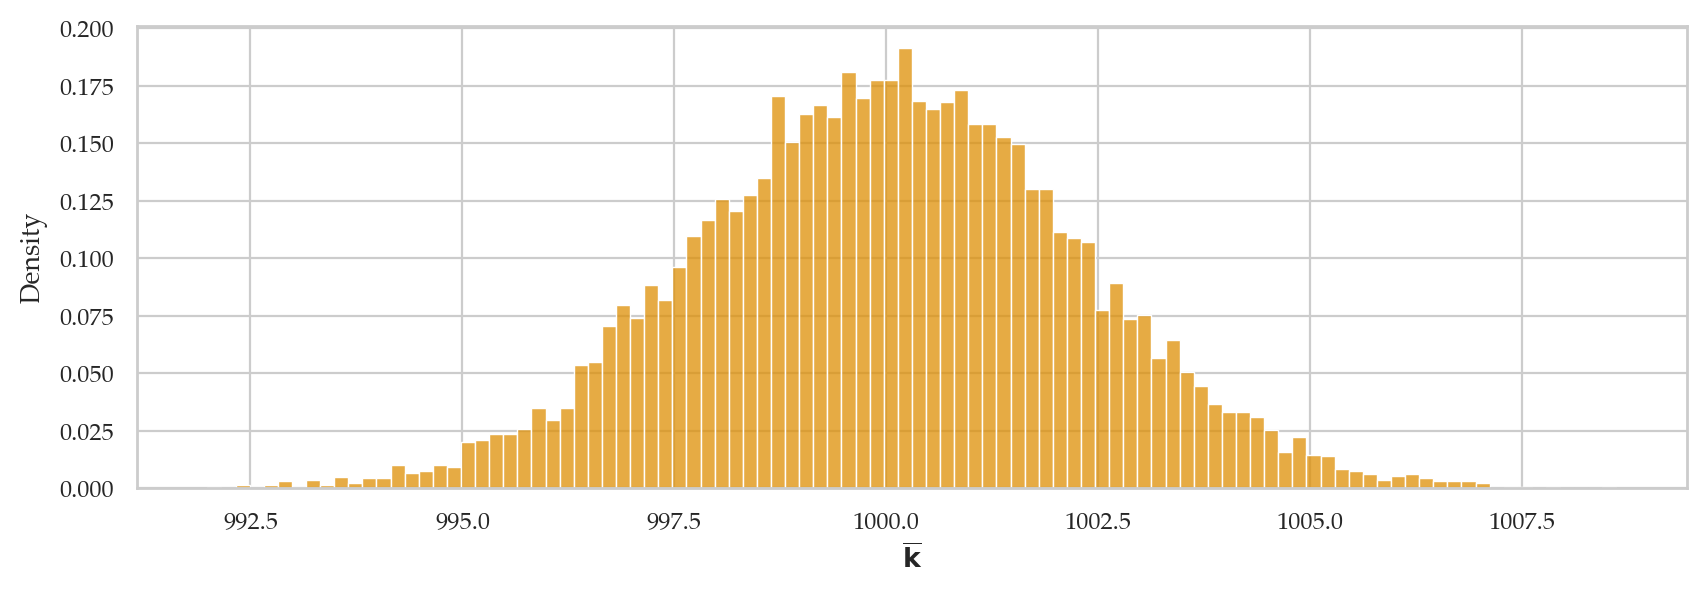

In [12]:
from stats_helpers import gen_sampling_dist

kbars40 = gen_sampling_dist(rvK, statfunc=mean, n=n)
ax = sns.histplot(kbars40, stat="density", bins=100, color=orange, label="simulation")
_ = ax.set_xlabel("$\overline{\mathbf{k}}$")

This is the ground truth...

## Analytical approximation from `ksample02`

In [13]:
obsmean02 = mean(ksample02)
obsmean02

997.9069999999999

In [14]:
obsvar02 = var(ksample02)
obsvar02

124.31760105263136

In [15]:
# standard error estimated from `ksample02`
n = ksample02.count()
seKhat02 = np.sqrt( obsvar02 / n )
seKhat02

2.4931666716510485

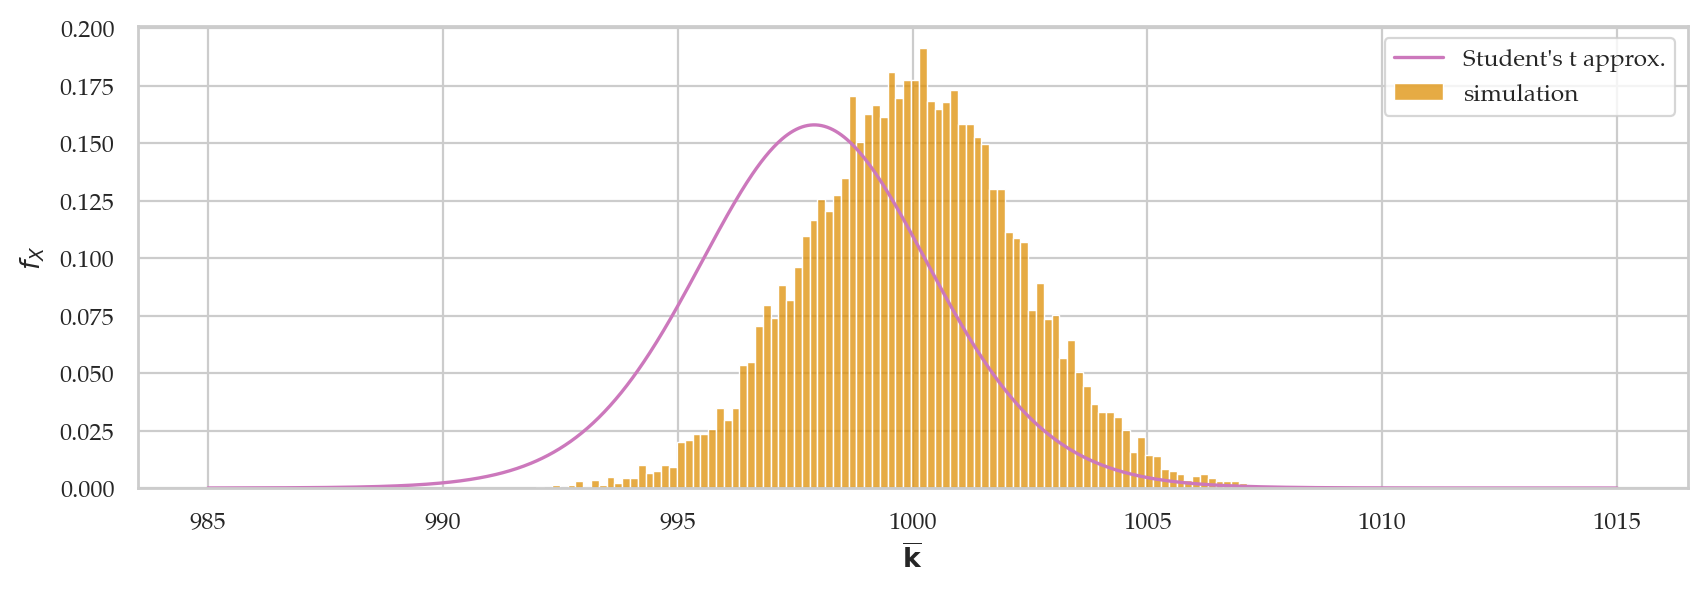

In [16]:
from scipy.stats import t as tdist

df = n - 1  # degrees of freedom
rvKbarA = tdist(df, loc=obsmean02, scale=seKhat02)

ax = sns.histplot(kbars40, stat="density", bins=100, color=orange, label="simulation")
plot_pdf(rvKbarA, ax=ax, xlims=[985,1015], color=purple, label="Student's t approx.")
_ = ax.set_xlabel("$\overline{\mathbf{k}}$")

## Bootstrap estimate based on `ksample02`

<AxesSubplot: ylabel='Density'>

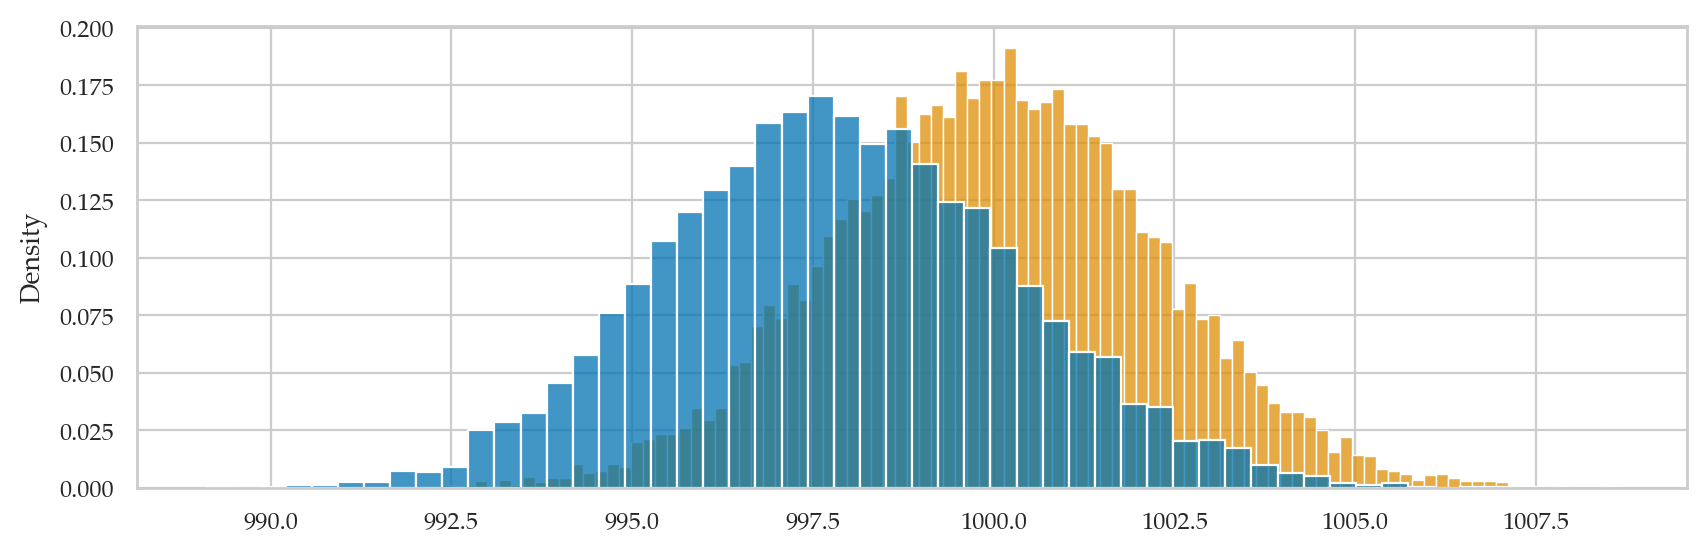

In [17]:
from stats_helpers import bootstrap_stat

# true sampling distribution
ax = sns.histplot(kbars40, stat="density", bins=100, color=orange, label="simulation")

# boostrap estimated sampling dist from sample `ksample02`
kbars02_boot = bootstrap_stat(ksample02, statfunc=mean)
sns.histplot(kbars02_boot, bins=50, stat="density", ax=ax)

## Picture A: estimated mean and std 


Picture A: norm(kbar, sehat) (the one nobody shows): a realistic experimenter who only knows ksample will make their "best guess" of the population mean as kbar = mean(ksample), then draw the sampling distribution centered at kbar, as in this figure:
https://minireference.com/static/tmp/sampling_dist_mean_rvK_and_N_T_boot_approx_from_particualr_sample_n7.png

I think nobody wants to shows this kind of figure because it looks really bad. Look how far off the CLT and bootstrap approximations are relative to the true population mean mu=1000.

sample mean = 997.9069999999999
 sample var = 124.31760105263136
 sample std = 11.149780314097285


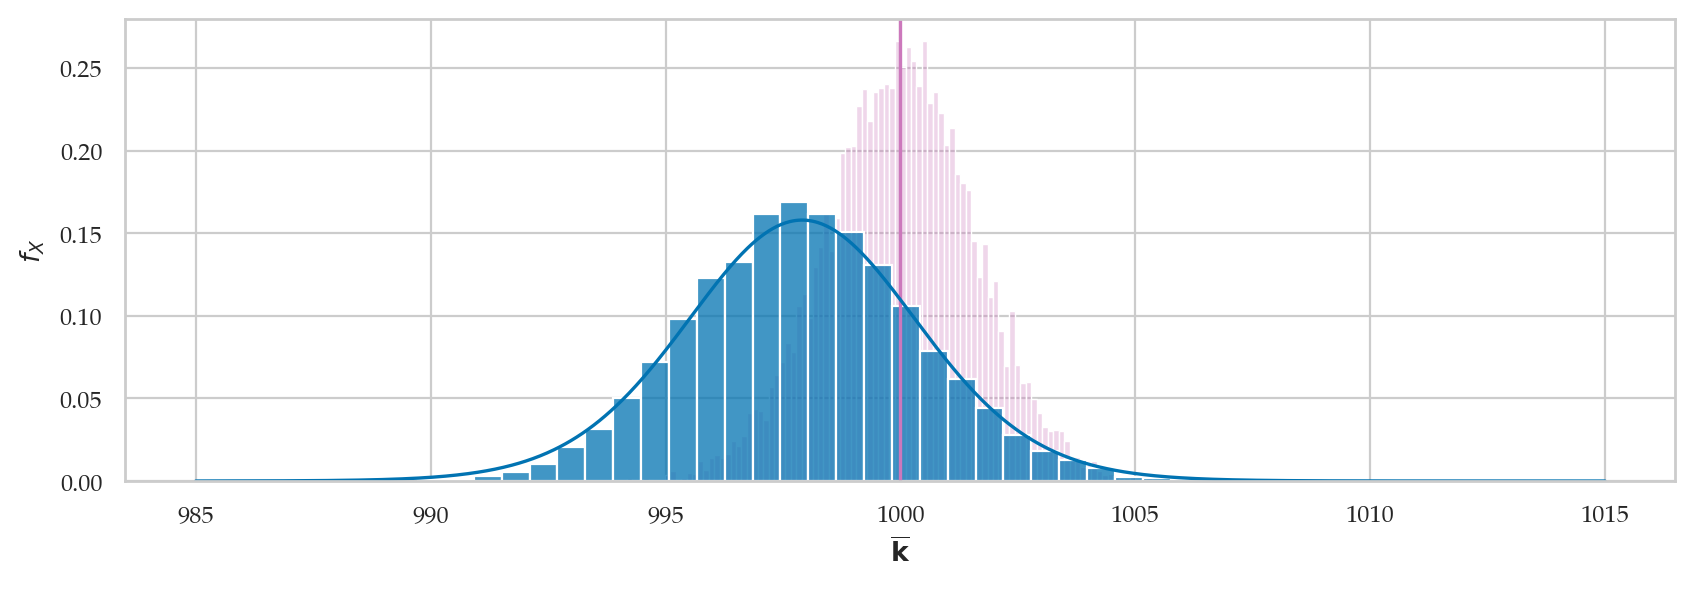

In [18]:
fig, ax = plt.subplots()

# true sampling distribution
kbars40 = gen_sampling_dist(rvK, statfunc=mean, n=40)
sns.histplot(kbars40, stat="density", ax=ax, bins=100,
                  label="simulation", alpha=0.3, color="m")

# populatin mean
ax.axvline(rvK.mean(), linestyle="-", color='m')

# particular sample
n = ksample02.count()
obsmean02 = mean(ksample02)
obsvar02 = var(ksample02)
print("sample mean =", obsmean02)
print(" sample var =", obsvar02)
print(" sample std =", np.sqrt(obsvar02))

# analytical approximation based on `ksample02` mean and var
from scipy.stats import t as tdist
df = n - 1  # degrees of freedom
seKhat02 = np.sqrt( obsvar02 / n )
rvKbarA = tdist(df, loc=obsmean02, scale=seKhat02)
plot_pdf(rvKbarA, ax=ax, xlims=[985,1015], color=blue, label="Student's t approx.")

# boostrap approx
kbars02_boot = bootstrap_stat(ksample02, statfunc=mean)
sns.histplot(kbars02_boot, bins=30, stat="density", ax=ax, label="boostrap approx.")

# add x-axis label and rm legend
_ = ax.set_xlabel("$\overline{\mathbf{k}}$")
ax.get_legend().remove()

## Picture B: centred around the population mean

`norm(mu_K, seKhat02)` (centered on true population mean):  this plot describes some hypothetical half-knowledge scenario, where the experimenter knows population mean mu, but doesn't know the variance, so we use CLT or BOOT for the estimated dispersion, but show dist. centered at muK (the population mean).

It's a tricky business... because Picture A is very ugly (reader might feel estimation process is hopeless), but it is real (shows how to calc. CI for population mean).

On the other hand Picture B is nicer to see (yeeey look how nicely the fat tails of the t-distribution fit the histogram of kbars better), but doesn't describe any realistic scenario, or calculation we actually do.


sample mean = 997.9069999999999
 sample var = 124.31760105263136
 sample std = 11.149780314097285


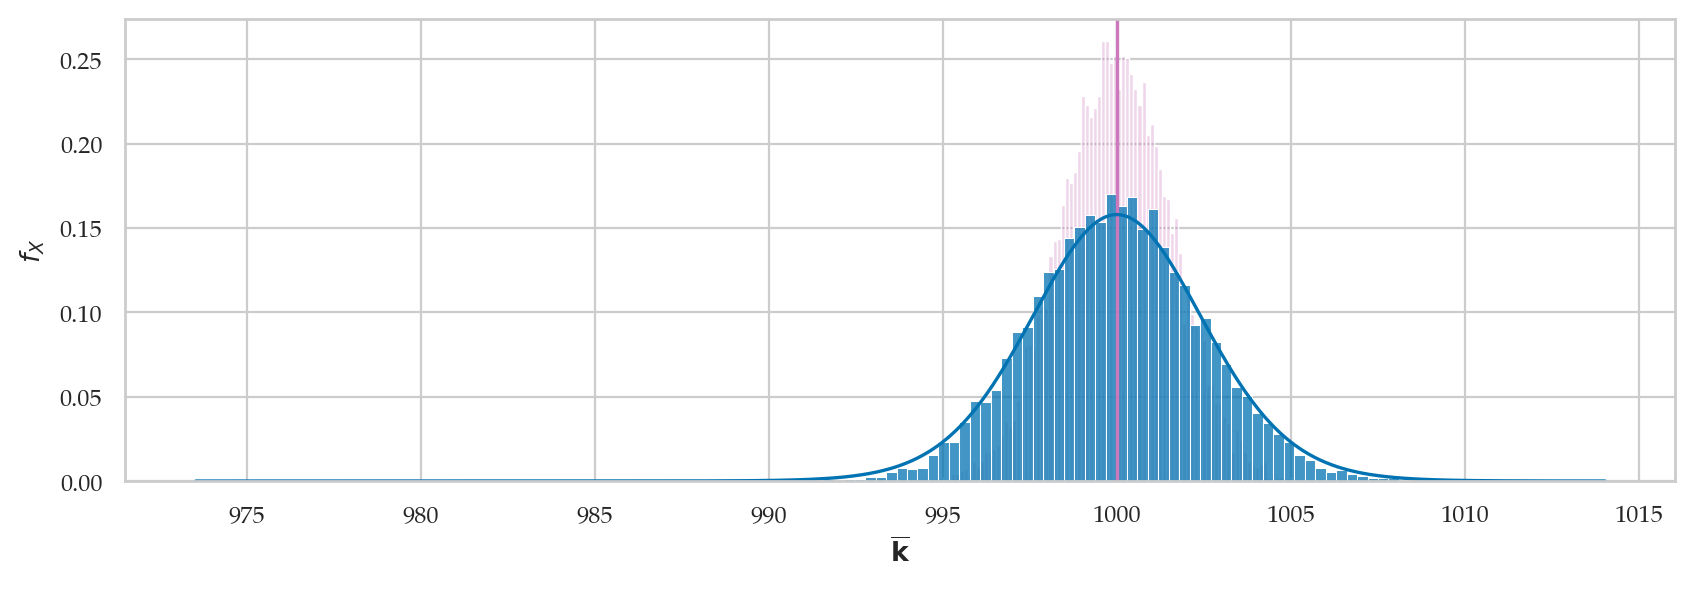

In [19]:
fig, ax = plt.subplots()

# true sampling distribution
kbars40 = gen_sampling_dist(rvK, statfunc=mean, n=40)
sns.histplot(kbars40, stat="density", ax=ax, bins=100,
                  label="simulation", alpha=0.3, color="m")

# populatin mean
ax.axvline(rvK.mean(), linestyle="-", color='m')

# particular sample
n = ksample02.count()
obsmean02 = mean(ksample02)
obsvar02 = var(ksample02)
print("sample mean =", obsmean02)
print(" sample var =", obsvar02)
print(" sample std =", np.sqrt(obsvar02))

# analytical approximation based on estimated var from `ksample02`
#   we draw the distribution centred around the true population mean
#   to focus on the variance-estimation aspect...
from scipy.stats import t as tdist
df = n - 1  # degrees of freedom
seKhat02 = np.sqrt( obsvar02 / n )
rvKbarB = tdist(df, loc=rvK.mean(), scale=seKhat02)
plot_pdf(rvKbarB, ax=ax, color=blue, label="Student's t approx.")

# boostrap approx
kbars02_boot = bootstrap_stat(ksample02, statfunc=mean)
kbars02_boot = np.array(kbars02_boot)
kbars02_boot_shifted = kbars02_boot - obsmean02 + rvK.mean()
sns.histplot(kbars02_boot_shifted, stat="density", ax=ax, label="boostrap approx.")

# add x-axis label and rm legend
_ = ax.set_xlabel("$\overline{\mathbf{k}}$")
ax.get_legend().remove()

## Picture C

Perhaps we need a third picture, to explain we're really talking...

Picture C: norm(0, sehat) = the distribution of ∆ = kbar - muK, which shows the deviation of the sample mean from the population mean. This way it becomes clear the symmetry of the situation:   (1) if you know mu, then you have a distribution of where xbars might fall, and (2) if you know kbar, then you have a distribution for where the unknown mu might be.

I might have to show Picture C because I'm ashamed of showing Picture A and I think Picture B is misleading...

... but if we're doing kbar - muK, might as well go all the way to a pivotal quantity  t  = (kbar - muK)/sehat ...


sample mean = 997.9069999999999
 sample var = 124.31760105263136
 sample std = 11.149780314097285


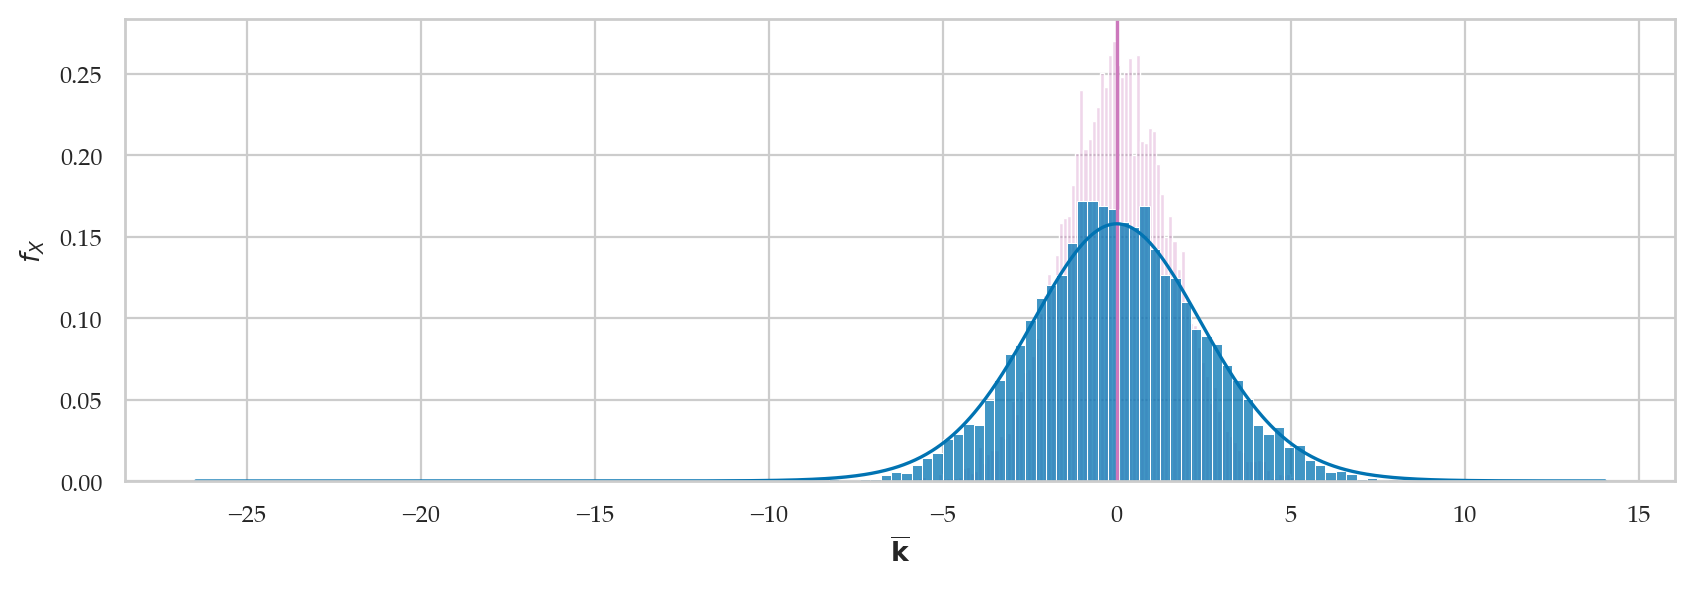

In [20]:
fig, ax = plt.subplots()

# true sampling distribution
kbars40 = gen_sampling_dist(rvK, statfunc=mean, n=40)
kbars40 = np.array(kbars40)
kbars40_devs =  kbars40 - rvK.mean()
sns.histplot(kbars40_devs, stat="density", ax=ax, bins=100,
                  label="simulation", alpha=0.3, color="m")

# zero deviation
ax.axvline(0, linestyle="-", color='m')

# particular sample
n = ksample02.count()
obsmean02 = mean(ksample02)
obsvar02 = var(ksample02)
print("sample mean =", obsmean02)
print(" sample var =", obsvar02)
print(" sample std =", np.sqrt(obsvar02))

# analytical approximation based on estimated var from `ksample02`
#   we plot the distribution of the difference: mu_k - kbar
from scipy.stats import t as tdist
df = n - 1  # degrees of freedom
seKhat02 = np.sqrt( obsvar02 / n )
rvKbarC = tdist(df, loc=0, scale=seKhat02)
plot_pdf(rvKbarC, ax=ax, color=blue, label="Student's t approx.")

# boostrap approx
kbars02_boot = bootstrap_stat(ksample02, statfunc=mean)
kbars02_boot = np.array(kbars02_boot)
kbars02_boot_shiftedC = kbars02_boot - obsmean02
sns.histplot(kbars02_boot_shiftedC, stat="density", ax=ax, label="boostrap approx.")

# add x-axis label and rm legend
_ = ax.set_xlabel("$\overline{\mathbf{k}}$")
ax.get_legend().remove()